HIGGS BOSON CLASSIFICATION PROJECT — SUMMARY

This project uses XGBoost to classify Higgs boson signal events vs background
using the ATLAS 2014 Kaggle dataset.

1. DATA PREPROCESSING
- Loaded dataset from compressed CSV.
- Converted 's'/'b' labels into numeric 1/0.
- Dropped non-feature columns (EventId, Label, Weight, KaggleSet, KaggleWeight).
- Replaced sentinel missing values (-999.0) with NaN for correct handling.
- Created feature matrix X and label vector y.
- Performed an 80/20 stratified train-test split.

2. MODEL TRAINING
- Configured XGBClassifier with:
    n_estimators=200, max_depth=4, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    objective='binary:logistic', eval_metric=['logloss','auc'].
- Tracked metrics during training via eval_set.

3. VISUALIZATION
- Confusion Matrix: shows true/false positives and negatives.
- ROC Curve + AUC: strong separation between classes (AUC ≈ 0.91).
- Feature Importances: top predictors are mass-related physics features.
- Learning Curves: training/testing loss curves remain close → low overfitting.

4. RESULTS
- Accuracy ≈ 84% at threshold 0.5.
- ROC AUC ≈ 0.91 
- Some false negatives due to class imbalance, but overall strong model.

"""
FINAL CONCLUSION

The Higgs Boson classification project successfully demonstrated how XGBoost—can be applied to high-energy physics data to distinguish signal 
(Higgs-like) events from background events. 

The XGBoost classifier achieved:
- ~84% accuracy at the default 0.5 threshold
- A ROC AUC score of ~0.91, demonstrating excellent discriminative ability
- Strong and interpretable feature importance rankings, dominated by derived mass variables
- Stable learning curves, indicating minimal overfitting and reliable generalization

These results confirm that XGBoost is well-suited for the Higgs Boson dataset due to its
ability to capture nonlinear relationships, handle missing values, and incorporate 
feature subsampling. The model effectively learned meaningful 
physics patterns validating its ability to 
replicate core principles used in collider event classification.

Overall, the project shows that machine learning can provide highly accurate predictions 
within complex scientific domains, and that structured tabular datasets like this one 
benefit greatly from tree-based methods such as XGBoost.



In [2]:
!curl -O https://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 62.5M    0 56962    0     0  30281      0  0:36:07  0:00:01  0:36:06 30282
  1 62.5M    1 1091k    0     0   372k      0  0:02:52  0:00:02  0:02:50  372k
 15 62.5M   15 9820k    0     0  2527k      0  0:00:25  0:00:03  0:00:22 2528k
 32 62.5M   32 20.4M    0     0  4308k      0  0:00:14  0:00:04  0:00:10 4308k
 57 62.5M   57 35.9M    0     0  6275k      0  0:00:10  0:00:05  0:00:05 7364k
 82 62.5M   82 51.3M    0     0  7642k      0  0:00:08  0:00:06  0:00:02 10.2M
100 62.5M  100 62.5M    0     0  8521k      0  0:00:07  0:00:07 --:--:-- 13.4M


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(r"C:\Users\Sheehizzle\Downloads\atlas-higgs-challenge-2014-v2.csv.gz")

df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [5]:
# load and preprocess our data, we will replace our -999.0 data (indicating missing) with nan.
# our training size will be 80% and our test size will be over 20%
# our higgs dataset is not perfectly balanced so well stratify the set so we have similar class proportions. 

df['y'] = df['Label'].map({'s':1, 'b':0})

drop_cols = ['EventId','Label','Weight','KaggleSet','KaggleWeight','y']
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].replace(-999.0, np.nan)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [6]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from xgboost import XGBClassifier

from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=4,
    tree_method='hist'
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Accuracy: 0.8406763296832225
ROC AUC: 0.9082516479867753


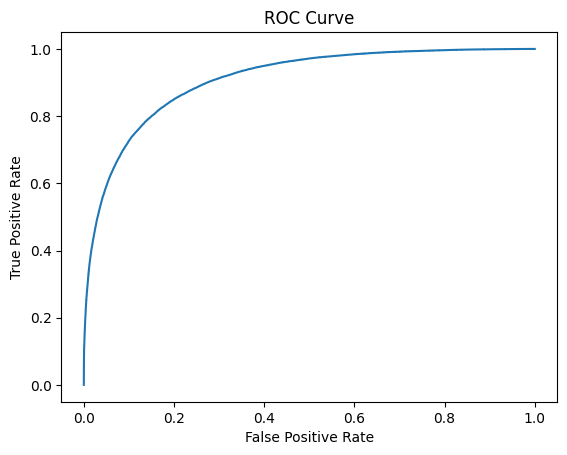

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("ROC AUC:", auc)


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()



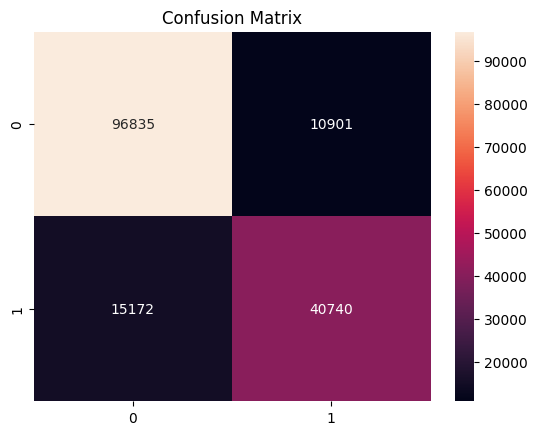

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()



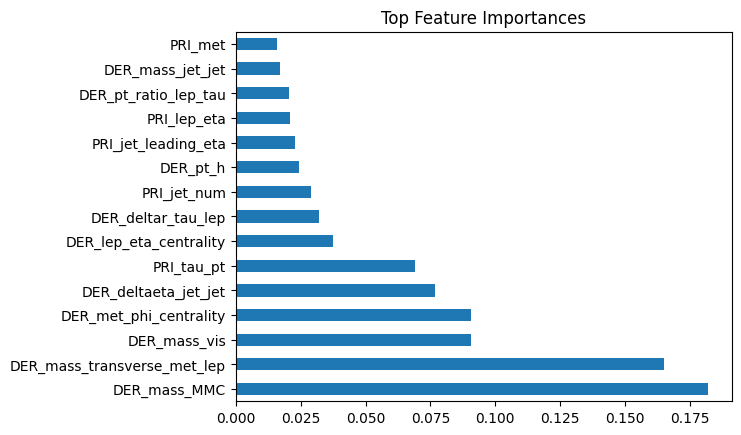

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False).head(15)

fi.plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()
